# Chapter 04 신경망 학습



학습 : 훈련 데이터로부터 가중치 매개변수의 최적값을 자동으로 획득하는 것

규칙을 '사람' 이 만드는 방식에서 '기계'가 데이터로부터 배우는 방식으로 패러다임이 전환됨.

- 머신러닝에서는 특징을 사람이 설계하는 것에 반해, **신경망**은 중요한 특성까지도 스스로 학습한다.

 딥러닝을 'end-to-end machine learning' 이라고도 한다.

 ---


### 4.2 손실 함수

손실함수 : 신경망 성능의 '나쁨'을 나타내는 지표

- 오차제곱합 (SSE) :

 **E = 1/2 ∑ (예측값 - 정답)²**

In [7]:
import numpy as np

# 오차제곱합 구현
def sum_squares_error(y, t):
    return 0.5 * np.sum((y-t)**2)

t = [0 ,0, 1, 0, 0, 0, 0, 0 ,0, 0]   # 정답 == 2라는 뜻 (원-핫 인코딩)

# y: 신경망의 소프트맥스 함수의 출력
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]   # '2'일 확률이 제일 높다고 추정
print(sum_squares_error(np.array(y), np.array(t)))

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]   # '7'일 확률이 제일 높다고 추정
print(sum_squares_error(np.array(y), np.array(t)))

# 손실함수의 값이 더 작은 것을 정답에 더 가까울 것으로 판단!

0.09750000000000003
0.5975


- 교차 엔트로피 오차 : 

 **E = - ∑ (정답 x log(예측값))**

 --> 정답일 때 1, 아닐 때 0이므로 정답일 때의 추정의 자연로그를 계산하는 식이 된다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


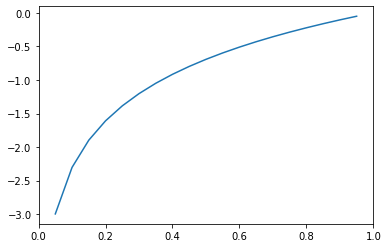

In [21]:
# 자연로그 그래프
import matplotlib.pyplot as plt
x = np.arange(0.0, 1.0, 0.05)
y = np.log(x)
plt.plot(x, y)
plt.xlim(0, 1)
plt.show()

정답의 예측값 ( 신경망의 출력값 )이 0에 가까울수록 오차가 커지고, 1에 가까워질수록 오차가 작아진다!

In [23]:
# 교차 엔트로피 구현
def cross_entropy_error(y, t):
    delta = 1e-7    # 아주 작은 값
    return -np.sum(t * np.log(y+delta))

# delta를 더해준 이유는 log()에 0이 들어가면 오류가 발생하기 때문

In [40]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]  # 정답은 '2'
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]  # 정답 '2'로 예측
print(cross_entropy_error(np.array(y), np.array(t)))

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]  # 정답 '7'로 예측
print(cross_entropy_error(np.array(y), np.array(t)))    

0.510825457099338
2.302584092994546


한 개의 데이터에 대해서 손실함수를 생각했는데, N개의 손실함수의 값을 다 구하여 평균을 내야한다!

 **E = - 1/N ∑ (정답 x log(예측값))**   [ N = 데이터 개수 ]

--> 데이터가 많아지면 시간이 많이 걸림...

- **미니배치 학습** :

 훈련 데이터로부터 일부만 골라 학습을 수행

In [113]:
# mnist 데이터셋 불러오기
import sys
import os
import numpy as np
path = '/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master'
sys.path.append(path)
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True) # 정규화o, 원-핫 인코딩o

print(x_train.shape)    # 훈련 이미지
print(t_train.shape)    # 정답 레이블

(60000, 784)
(60000, 10)


In [69]:
train_size = x_train.shape[0]  # == len(x_train)
batch_size = 10   # 배치크기 지정
batch_mask = np.random.choice(train_size, batch_size)  # random.choice(x, n): 0이상 x미만인 n개의 난수 생성
x_batch = x_train[batch_mask]   # batch_size 만큼 뽑음
t_batch = t_train[batch_mask]
print(x_batch.shape)

(10, 784)


In [71]:
np.random.choice(60000,10)

array([25862, 40590,  9127, 11671, 44181, 21164, 26575, 28946, 33998,
       34726])

In [92]:
# (배치용) 교차 엔트로피 구현하기
def cross_entropy_error(y, t):  # y: 신경망의 출력, t: 정답 레이블

# 왜 바꿀까 형태를 ??
    if y.ndim == 1:     # 데이터가 하나라면 reshape 적용
        t = t.reshape(1, t.size)  # t.size : t의 총 원소 개수
        y = y.reshape(1, y.size)  # == y.flatten()
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

10

In [ ]:
# 정답 레이블이 원-핫 인코딩이 아닌 경우
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

    # 원-핫 인코딩에서 정답이 0인 경우는 무시하고 계산

정확도 대신 **손실함수**를 사용하는 이유 :

- 신경망에서 손실함수를 가능한 작게 하는 매개변수의 값을 찾는데에 '미분'이 중요한 역할을 하기 때문에.

- 정확도를 지표로 하면 매개변수의 미분이 대부분의 장소에서 0이 된다.

 정확도는 매개변수의 미소한 변화에 거의 반응을 보이지 않고, 있더라도 불연속적으로 갑자기 변화한다..

== '계단 함수'를 활성화 함수로 사용하지 않는 이유와 같다

### 4.3 수치 미분

1
